# **Import libs**

In [1]:
import sys
import string
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

spotify_path = '../code/Spotify'
sys.path.append(spotify_path)

from Spotify import Spotify as sp

# **Initializing the API with the credentials**

In [ ]:
sp.initialize('../credentials/credentials_file.json')

# **Performing the artist search**

In [ ]:
artists = []

for letter in string.ascii_letters:
  for offset in tqdm(range(0, 1000, 50), desc=f'Letra {letter}'):
    results = sp.search(q=letter, type='artist', limit=50, offset=offset)
    artists += results['artists']['items']

# **Creating a network with the obtained information and processing/removing some columns**

In [ ]:
df = pd.DataFrame(artists)
df['external_urls'] = df['external_urls'].map(lambda x: x['spotify'])
df['followers'] = df['followers'].map(lambda x: x['total'])
df['genres'] = df['genres'].map(lambda x: ', '.join(x))
df.drop(columns=['href', 'images', 'type'], inplace=True)
display(df)

# **Removing artists that appear more than once in the dataset**

In [ ]:
df_clean = df.drop_duplicates()
df_clean.reset_index(inplace=True, drop='index')
df_clean

# **Removing artists without a genre**

In [ ]:
df_clean.loc[:, 'genres'] = df['genres'].replace('', np.nan)
df_clean = df_clean.dropna(subset=['genres'])
df_clean.reset_index(drop=True, inplace=True)
df_clean

# **Removing artists who are in only one genre by themselves**

In [ ]:
genres = {}
for index in range(len(df_clean)):
    genres_line = df_clean['genres'][index]
    genres_line = genres_line.split(', ')
    for genre in genres_line:
        if genre not in genres:
            genres[genre] = 0
        genres[genre] += 1

In [ ]:
genres_to_delete = []
for genre, quantity in genres.items():
    if quantity == 1:
        genres_to_delete.append(genre)
genres_to_delete

In [ ]:
for index in range(len(df_clean)):
    genres_line = df_clean['genres'][index]
    genres_line = genres_line.split(', ')
    list_aux = []
    for genre in genres_line:
        if genre not in genres_to_delete:
            list_aux.append(genre)
    if len(genres_line) != len(list_aux):
        if len(list_aux) > 0: 
            new_value = ', '.join(list_aux)
        else: 
            new_value = np.nan
        df_clean.loc[index, 'genres'] = new_value
df_clean = df_clean.dropna(subset=['genres'])
df_clean.reset_index(inplace=True, drop='index')
df_clean

# **Analyzing the DataFrame**

## **Popularity**

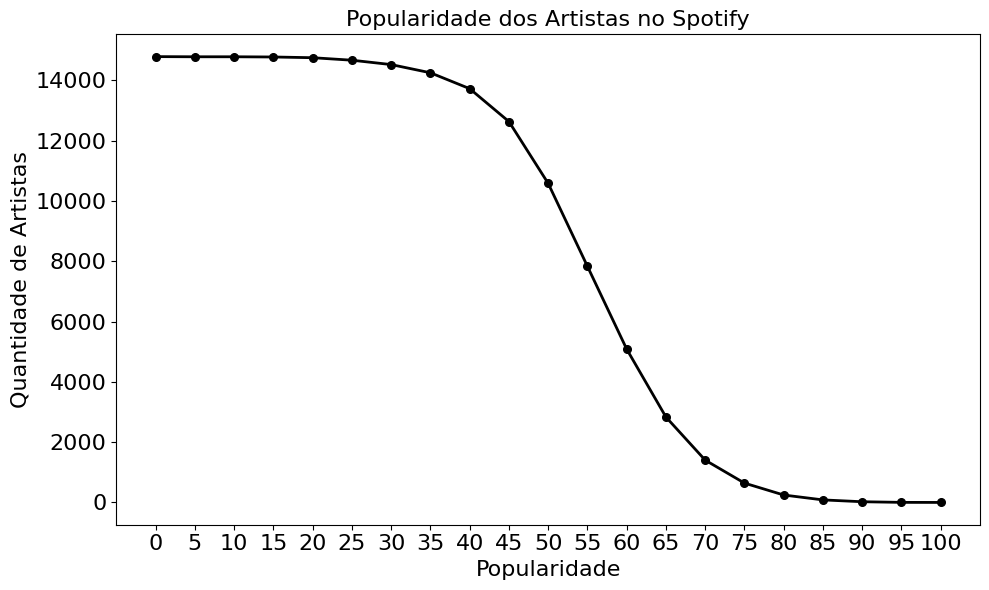

In [3]:
x_values = list(range(0, 105, 5))
quantity_of_artists = [len(df_clean[df_clean['popularity'] >= value]) for value in x_values]
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_values, quantity_of_artists, marker='o', color='black', markersize=5.5, linewidth=2)

ax.set_xticks(x_values)
ax.set_title('Popularidade dos Artistas no Spotify', fontsize=16)
ax.set_xlabel('Popularidade', fontsize=16)
ax.set_ylabel('Quantidade de Artistas', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

fig.savefig('fig_popularity.png', dpi=300, bbox_inches='tight')

## **Number of artists per genre**

In [4]:
genres = {}
for index in range(len(df_clean)):
    genres_line = df_clean['genres'][index]
    genres_line = genres_line.split(', ')
    for genre in genres_line:
        if genre not in genres:
            genres[genre] = 0
        genres[genre] += 1
sorted_genres = dict(sorted(genres.items(), key=lambda item: item[1], reverse=True))
print(f'Quantity of genres: {len(genres)}')

Quantity of genres: 2392


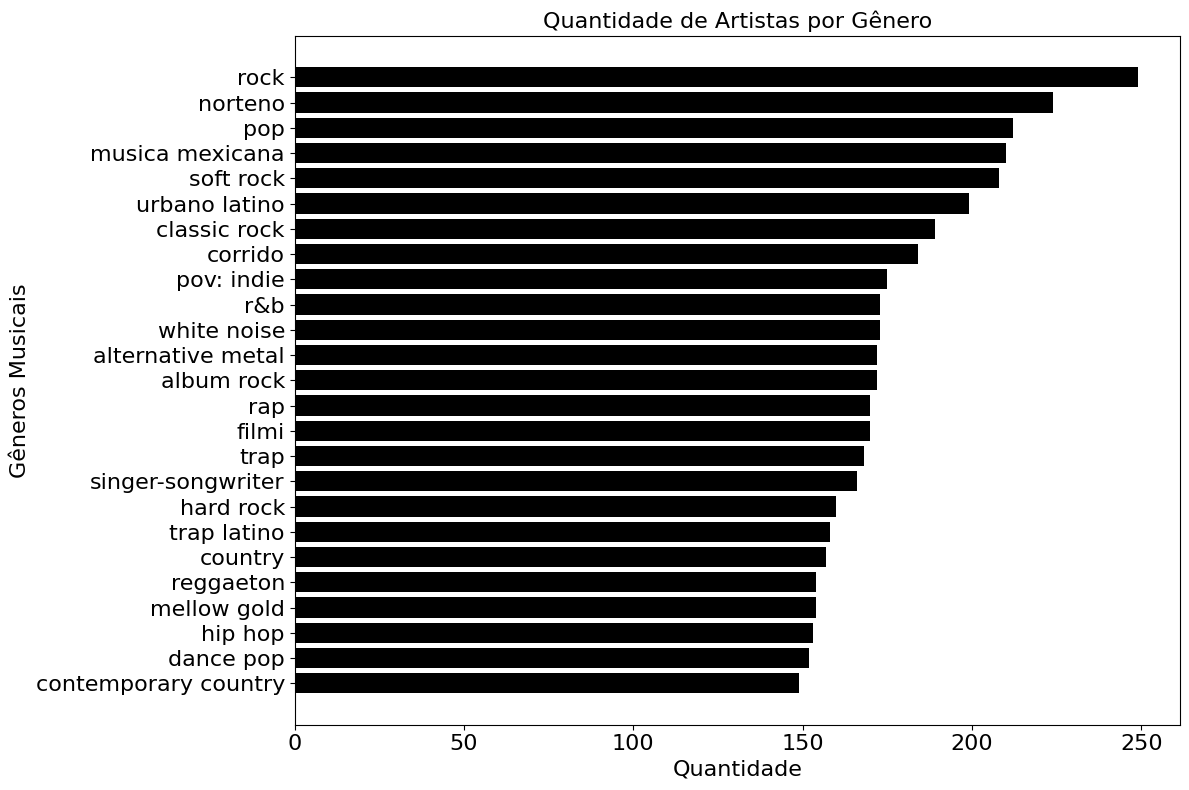

In [5]:
sorted_genres = dict(list(sorted_genres.items())[:25])

genres = list(sorted_genres.keys())
genres = genres[::-1]
values = list(sorted_genres.values())
values = values[::-1]

fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(genres, values, color='black')

ax.set_xlabel('Quantidade', fontsize=16)
ax.set_ylabel('Gêneros Musicais', fontsize=16)
ax.set_title('Quantidade de Artistas por Gênero', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

fig.savefig('fig_genres.png', dpi=300, bbox_inches='tight')

# **Finding artists related to the artists in the DataFrame**

In [ ]:
with open('artist_related_artists.csv', 'a+') as file:
    file.seek(0)
    content = file.readlines()
    for i in tqdm(range(len(content), len(df_clean))):
        artist_related_artists = sp.artists_related_to(df_clean['id'][i])
        artist_related_artists_str = ', '.join([artist['id'] for artist in artist_related_artists['artists']])
        file.write(f"{df_clean['id'][i]}\t{(artist_related_artists_str)}")
        file.write('\n')

## **Adding related artists to the DataFrame**

In [ ]:
df_related_artists = pd.read_csv('artist_related_artists.csv', header=None, names=['artist_id', 'related_artists_ids'], sep='\t')
df_related_artists

In [ ]:
artist_related_artists_list = []
for index in range(len(df_related_artists)):
    if type(df_related_artists['related_artists_ids'][index]) == float: 
        artist_related_artists_list.append(np.nan)
        continue
    related_artists_ids = df_related_artists['related_artists_ids'][index].split(', ')
    list_aux = []
    for artist_id in related_artists_ids:
        if artist_id in list(df_clean['id']):
            list_aux.append(artist_id)
    new_value = ', '.join(list_aux)
    artist_related_artists_list.append(new_value)

df_clean.loc[:, 'related_artists_ids'] = artist_related_artists_list
df_clean

# **Saving the DataFrame**

In [ ]:
df_clean.to_csv('spotify_artists.csv', index=False)